In [2]:
import pandas as pd
import numpy as np
import re
import glob
from pathlib import Path
from captum.attr import IntegratedGradients
from NegativeClassOptimization.preprocessing import *
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from pathlib import Path
import torch
import torch.nn as nn
import pandas as pd
from captum.attr import IntegratedGradients
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from tqdm import tqdm

In [3]:
def compute_binary_metrics(y_test_pred, y_test_true) -> dict:
    acc = metrics.accuracy_score(y_true=y_test_true, y_pred=y_test_pred)
    recall= metrics.recall_score(y_true=y_test_true, y_pred=y_test_pred)
    prec = metrics.precision_score(y_true=y_test_true, y_pred=y_test_pred)
    f1 = metrics.f1_score(y_true=y_test_true, y_pred=y_test_pred)
    return [acc, recall, prec, f1]

In [5]:
set(config.ANTIGENS) - set(pos_ag)

{'1ADQ',
 '1FBI',
 '1H0D',
 '1NSN',
 '1OB1',
 '1WEJ',
 '2YPV',
 '3RAJ',
 '3VRL',
 '5E94'}

In [17]:
neg_ags

['2YPV',
 '1ADQ',
 '5E94',
 '3VRL',
 '1NSN',
 '1FBI',
 '3RAJ',
 '1OB1',
 '1WEJ',
 '1H0D']

In [40]:
vs1s_open_res = []
for pos_ag in tqdm(config.ANTIGENS, desc='positive antigen'):
    neg_ags_set = set(config.ANTIGENS)
    neg_ags_set.discard(pos_ag)
    neg_ags = list(neg_ags_set)
    for neg_ag in tqdm(neg_ags, desc='negative_antigen'):
        model_path = glob.glob(f"./torch_models/Frozen_MiniAbsolut_ML/1v1/seed_0/split_42/{pos_ag}__vs__{neg_ag}/swa_model/data/model.pth")[0]
        model = torch.load(model_path, map_location=torch.device("cpu"))
        mps_device = torch.device("mps")
        model.to(mps_device)

        out_neg_ags = neg_ags_set.copy()
        out_neg_ags.discard(neg_ag)
        for out_neg_ag in tqdm(list(out_neg_ags), desc='out_negative_antigen'):
            dataset = glob.glob(f'./torch_models/Frozen_MiniAbsolut_ML/1v1/seed_0/split_42/{pos_ag}__vs__{out_neg_ag}/*_test_dataset.tsv')[0]
            df = pd.read_csv(dataset, sep='\t')
            slides_pos = df[df['y'] == 1]['Slide']
            slides_neg = df[df['y'] == 0]['Slide']
            #jsd = jensen_shannon_divergence_slides(slides_neg, slides_pos)
            df['X'] = df['Slide'].apply(onehot_encode)
            X = torch.tensor(df['X'].tolist(), dtype=torch.float32).to(mps_device)
            y = torch.tensor(df['y'].tolist(), dtype=torch.float32).to(mps_device)
            y_pred, logits = model(X, return_logits = True)
            y_pred = y_pred.cpu().detach().numpy().reshape(-1).round()
            y = y.cpu().detach().numpy()
            acc, recall, prec, f1 = compute_binary_metrics(y_pred, y)
            vs1s_open_res.append([acc, recall, prec, f1, pos_ag, neg_ag, out_neg_ag, 0, 42])        

positive antigen:   0%|          | 0/10 [00:00<?, ?it/s]








out_negative_antigen: 100%|██████████| 8/8 [00:08<00:00,  1.07s/it]









out_negative_antigen: 100%|██████████| 8/8 [00:08<00:00,  1.08s/it]









out_negative_antigen: 100%|██████████| 8/8 [00:08<00:00,  1.07s/it]









out_negative_antigen: 100%|██████████| 8/8 [00:08<00:00,  1.03s/it]









out_negative_antigen: 100%|██████████| 8/8 [00:08<00:00,  1.04s/it]









out_negative_antigen: 100%|██████████| 8/8 [00:08<00:00,  1.03s/it]









out_negative_antigen: 100%|██████████| 8/8 [00:08<00:00,  1.03s/it]









out_negative_antigen: 100%|██████████| 8/8 [00:08<00:00,  1.03s/it]









positive antigen:  10%|█         | 1/10 [01:15<11:17, 75.29s/it]








out_negative_antigen: 100%|██████████| 8/8 [00:08<00:00,  1.03s/it]









out_negative_antigen: 100%|██████████| 8/8 [00:08<00:00,  1.03s/it]









out_negative_antigen: 100%|██████████| 8/8 [00:08<00:00,  1.03s/it]









out_negative_an

In [55]:
df_vs1s_open = pd.DataFrame(vs1s_open_res, columns=['acc', 'recall', 'prec', 'f1', 'pos_ag', 'neg_ag', 'out_neg_ag', 'seed', 'split'])

In [56]:
df_vs1s_open.head()

,acc,recall,prec,f1,pos_ag,neg_ag,out_neg_ag,seed,split
0,0.8716,0.9916,0.799677,0.885357,3VRL,2YPV,1ADQ,0,42
1,0.9138,0.9916,0.858082,0.920022,3VRL,2YPV,5E94,0,42
2,0.9403,0.9916,0.899329,0.943213,3VRL,2YPV,1NSN,0,42
3,0.8925,0.9916,0.827575,0.902193,3VRL,2YPV,1FBI,0,42
4,0.8112,0.9916,0.728689,0.840054,3VRL,2YPV,3RAJ,0,42


<AxesSubplot:xlabel='pos_ag', ylabel='neg_ag-out_neg_ag'>

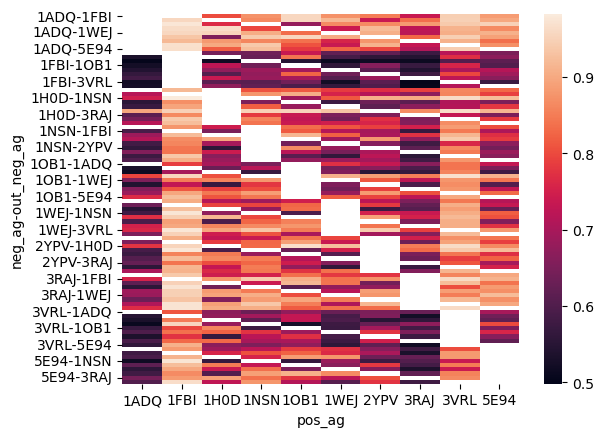

In [57]:
sns.heatmap(df_vs1s_open.pivot(columns = 'pos_ag', index = ['neg_ag','out_neg_ag'], values = 'acc'))

In [58]:
df_vs1s_open['train_task'] = 'vs 1'
df_vs1s_open['test_task'] = 'vs 1'
df_vs1s_open['test_ag'] = df_vs1s_open['pos_ag']
df_vs1s_open['test_seed_id'] = df_vs1s_open['seed']
df_vs1s_open['test_split_id'] = df_vs1s_open['split']
df_vs1s_open.rename(columns={'pos_ag': 'train_ag', 'neg_ag': 'train_neg', 'out_neg_ag': 'test_neg', 'seed': 'seed_id', 'split': 'split_id', 'prec': 'precision'}, inplace=True)

In [53]:
df_vs1s_open.to_csv('../data/1vs1_open.csv', index=False)

In [ ]:
Index(['acc', 'recall', 'precision', 'f1', 'train_task', 'train_ag',
       'train_neg', 'seed_id', 'split_id', 'test_task', 'test_ag', 'test_neg',
       'test_seed_id', 'test_split_id', 'train_jsd', 'test_jsd', 'closed_acc',
       'delta_jsd', 'delta_acc', 'delta_jsd_norm', 'delta_acc_norm',
       'dupl_filter'],
      dtype='object')

In [24]:
glob.glob(f'./torch_models/Frozen_MiniAbsolut_ML/1v1/seed_0/split_42/{pos_ag}__vs__{out_neg_ag}/*_test_dataset.tsv')[0]

IndexError: list index out of range

In [32]:
pos_ag

'3VRL'

In [33]:
set(config.ANTIGENS).difference(set(pos_ag))

{'1ADQ',
 '1FBI',
 '1H0D',
 '1NSN',
 '1OB1',
 '1WEJ',
 '2YPV',
 '3RAJ',
 '3VRL',
 '5E94'}

In [36]:
y = set(config.ANTIGENS)
y.discard(pos_ag)
y

{'1ADQ', '1FBI', '1H0D', '1NSN', '1OB1', '1WEJ', '2YPV', '3RAJ', '5E94'}

In [37]:
config.ANTIGENS

['3VRL',
 '1NSN',
 '3RAJ',
 '5E94',
 '1H0D',
 '1WEJ',
 '1ADQ',
 '1FBI',
 '2YPV',
 '1OB1']